
# IRRBB SIMULATION AND HEDGING FRAMEWORK

# This notebook provides a simplified IRRBB framework to analyse how changes in the yield curve affect bond prices and portfolio value. It simulates regulatory interest rate shocks (±200 bps), compares unhedged and hedged portfolios, and illustrates the roles of duration and convexity in interest rate risk management.



In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [90]:
maturities = np.array([0.5, 1, 2, 3, 5, 7, 10, 20, 30])
yields = np.array([0.036, 0.037, 0.038, 0.039, 0.041, 0.042, 0.043, 0.045, 0.046])

curve = pd.DataFrame({"Maturity": maturities,"Yield": yields})

curve


,Maturity,Yield
0,0.5,0.036
1,1.0,0.037
2,2.0,0.038
3,3.0,0.039
4,5.0,0.041
5,7.0,0.042
6,10.0,0.043
7,20.0,0.045
8,30.0,0.046


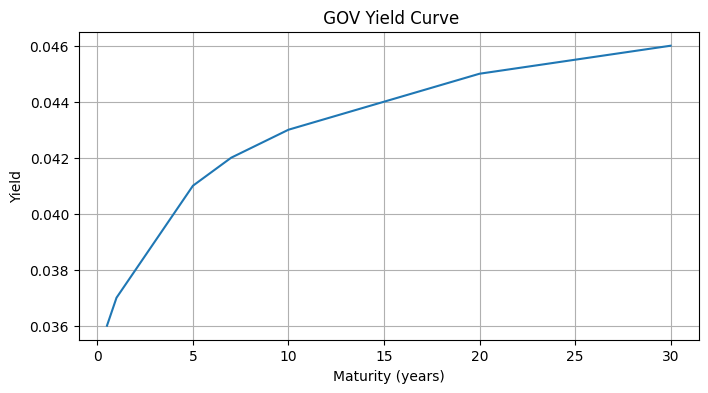

In [111]:
plt.figure(figsize=(8,4))
plt.plot(curve["Maturity"], curve["Yield"], marker="")
plt.title(" GOV Yield Curve")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield")
plt.grid(True)
plt.show()


In [92]:
def print_interpolated_yield(curve_func, maturity):
    """
    Stampa il rendimento interpolato in percentuale
    adattando automaticamente il testo alla scadenza richiesta.
    """
    y = float(curve_func(maturity))
    y_percent = y * 100
    print(f"{maturity}Y Yield (interpolated): {y_percent:.2f}%")


In [93]:
from scipy.interpolate import interp1d

curve_interp = interp1d(
    curve["Maturity"],
    curve["Yield"],
    kind="linear",
    fill_value="extrapolate")

print_interpolated_yield(curve_interp, 15)  #CHANGE NUM (es.15) TO VISUALIZE INTERPOLATE VALUE

15Y Yield (interpolated): 4.40%


In [94]:
import numpy as np

#
# GOVERNATIVE BOND PRICING
#
# - Bond plain vanilla
# - Cedole ANNUALI
# - Tassi della curva interpretati come zero rates
# - Capitalizzazione annuale
#
# cambiando la curva (base vs shock) cambia il prezzo del bond

def price_bond_annual(face_value, coupon_rate, maturity, curve_func):
    """
    Calcola il prezzo di un bond a cedola annuale dato un interpolatore di curva.

    face_value  : valore nominale (es. 100)
    coupon_rate : cedola annua (es. 0.03 = 3%)
    maturity    : scadenza del bond in anni (intero)
    curve_func  : funzione interpolata della curva (curve_interp)
    """

    price = 0.0

    # Ciclo sui flussi annuali
    for t in range(1, maturity + 1):

        # Tasso spot interpolato alla scadenza t
        y_t = float(curve_func(t))

        # Discount factor (capitalizzazione annuale)
        discount_factor = 1 / (1 + y_t) ** t

        # Cedola annuale
        cash_flow = face_value * coupon_rate

        # A scadenza aggiungo il rimborso del nominale
        if t == maturity:
            cash_flow += face_value

        price += cash_flow * discount_factor

    return price


In [95]:
### BOND PARAMETERS ###

face_value = 100        # NOMINAL
coupon_rate = 0.03      # ANNUAL %
maturity = 10           # X YEARS


In [96]:
price_base = price_bond_annual(
    face_value,
    coupon_rate,
    maturity,
    curve_interp)

print(f"Bond price (base curve): {price_base:.2f}")


Bond price (base curve): 89.79


In [97]:
# PARALLEL SHOCK SCENARIOS IRRBB

shock_up = 0.02     # +200 bps
shock_down = -0.02  # -200 bps

# SHOCK UP CURVE
curve_up = interp1d(
    maturities,
    yields + shock_up,
    kind="linear",
    fill_value="extrapolate")

# SHOCK DOWN CURVE
curve_down = interp1d(
    maturities,
    yields + shock_down,
    kind="linear",
    fill_value="extrapolate")


In [98]:
price_up = price_bond_annual(
    face_value,
    coupon_rate,
    maturity,
    curve_up)

price_down = price_bond_annual(
    face_value,
    coupon_rate,
    maturity,
    curve_down)

print(f"Bond price (+200 bps): {price_up:.2f}")
print(f"Bond price (-200 bps): {price_down:.2f}")


Bond price (+200 bps): 76.22
Bond price (-200 bps): 106.39


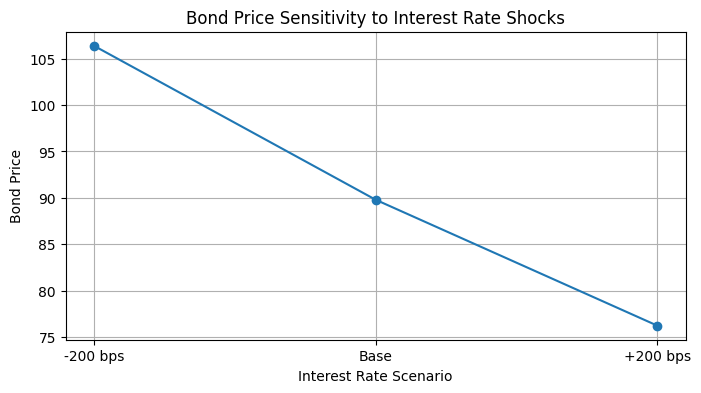

In [99]:
# BOND PRICES IN ALL SCENARIOS

scenarios = ["-200 bps", "Base", "+200 bps"]
bond_prices = [price_down, price_base, price_up]

import matplotlib.pyplot as plt

# PLOT BOND PRICES

plt.figure(figsize=(8, 4))
plt.plot(scenarios, bond_prices, marker="o")
plt.title("Bond Price Sensitivity to Interest Rate Shocks")
plt.xlabel("Interest Rate Scenario")
plt.ylabel("Bond Price")
plt.grid(True)
plt.show()


In [100]:
# CONVEXITY (stima da scenari +Δy e -Δy)

# Logica:
# - Duration/DV01 cattura l'effetto "lineare" (primo ordine)
# - Convexity cattura la curvatura della relazione prezzo-tasso (secondo ordine)
# - Con shock grandi (es. ±200 bps) la convexity diventa rilevante

def convexity_from_prices(P0, P_up, P_down, dy):
    """
    Stima la convexity usando una differenza centrale sui prezzi.

    P0     : prezzo base
    P_up   : prezzo con tassi +dy
    P_down : prezzo con tassi -dy
    dy     : shock in forma decimale (es. 0.02 per 200 bps)
    """
    return (P_down + P_up - 2 * P0) / (P0 * (dy ** 2))

dy = 0.02  # 200 bps = 0.02

conv = convexity_from_prices(price_base, price_up, price_down, dy)
print(f"Estimated Convexity (scenario-based): {conv:.6f}")


Estimated Convexity (scenario-based): 84.164030


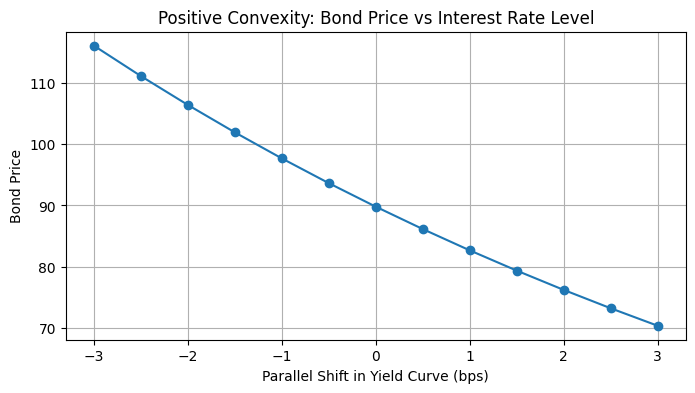

In [101]:
# PLOT: CONVEXITY POSITIVE (Bond plain vanilla)

rate_shifts = np.linspace(-0.03, 0.03, 13)  # -300  +300 bps

bond_prices_convex = []

for shift in rate_shifts:
    shocked_curve = interp1d(
        maturities,
        yields + shift,
        kind="linear",
        fill_value="extrapolate"
    )

    price = price_bond_annual(face_value,coupon_rate,maturity,shocked_curve)

    bond_prices_convex.append(price)

# Plot
plt.figure(figsize=(8,4))
plt.plot(rate_shifts * 100, bond_prices_convex, marker="o")
plt.title("Positive Convexity: Bond Price vs Interest Rate Level")
plt.xlabel("Parallel Shift in Yield Curve (bps)")
plt.ylabel("Bond Price")
plt.grid(True)
plt.show()


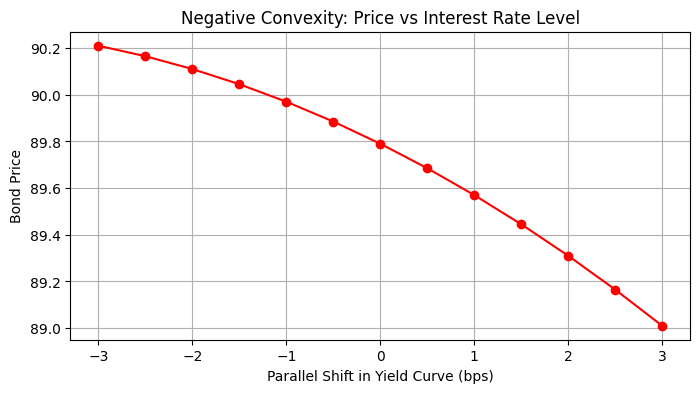

In [102]:
# PLOT: CONVEXITY NEGATIVA

# Funzione di prezzo concava
price_concave = price_base - 0.2 * rate_shifts * 100 - 0.02 * (rate_shifts * 100) ** 2

plt.figure(figsize=(8,4))
plt.plot(rate_shifts * 100, price_concave, marker="o", color="red")
plt.title("Negative Convexity: Price vs Interest Rate Level")
plt.xlabel("Parallel Shift in Yield Curve (bps)")
plt.ylabel("Bond Price")
plt.grid(True)
plt.show()


In [103]:

# MINI-BOND PORTFOLIO
#
# - maturity
# - weight (SUM = 1)

portfolio = [
    {"maturity": 3,  "weight": 0.3},
    {"maturity": 7,  "weight": 0.4},
    {"maturity": 15, "weight": 0.3}
]


# PRICING PORTFOLIO
# Il prezzo è la somma dei prezzi dei bond pesati

def price_portfolio(curve_func):
    total_price = 0

    for bond in portfolio:
        price = price_bond_annual(
            face_value,
            coupon_rate,
            bond["maturity"],
            curve_func
        )
        total_price += bond["weight"] * price

    return total_price

# PORTFOLIO PRICES
P_port_base = price_portfolio(curve_interp)
P_port_up   = price_portfolio(curve_up)
P_port_down = price_portfolio(curve_down)

print(f"Portfolio price (base): {P_port_base:.2f}")
print(f"Portfolio price (+200 bps): {P_port_up:.2f}")
print(f"Portfolio price (-200 bps): {P_port_down:.2f}")

#I bond con duration più elevata (es. 15 anni) pesano maggiormente nella perdita di valore in caso di rialzo dei tassi (+200 bps),
#perché i loro flussi vengono scontati a tassi più alti per più tempo.
#Questo rende il portafoglio strutturalmente esposto al rischio di tasso.


Portfolio price (base): 91.99
Portfolio price (+200 bps): 81.05
Portfolio price (-200 bps): 105.42


In [109]:
# @title
# IRS  HEDGING
# Proxy of IRS pay-fixed as:  SHORT position on a long duration bond

irs_maturity = 10
irs_notional = -0.4   # partial hedging (40% of portfolio)

def price_irs_proxy(curve_func):
    return irs_notional * price_bond_annual(
        face_value,
        coupon_rate,
        irs_maturity,
        curve_func)

###HEDGED PORTFOLIO

P_hedged_base = P_port_base + price_irs_proxy(curve_interp)
P_hedged_up   = P_port_up   + price_irs_proxy(curve_up)
P_hedged_down = P_port_down + price_irs_proxy(curve_down)

print("Hedged Portfolio")
print(f"Base: {P_hedged_base:.2f}")
print(f"+200 bps: {P_hedged_up:.2f}")
print(f"-200 bps: {P_hedged_down:.2f}")



Hedged Portfolio
Base: 56.07
+200 bps: 50.56
-200 bps: 62.86


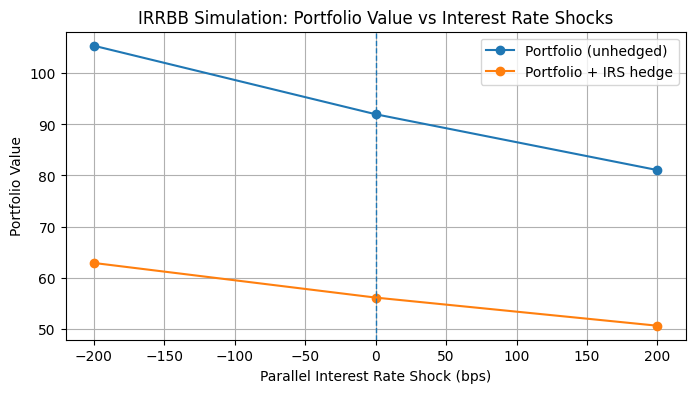

In [105]:
###GRAPHIC SCENARIOS

rate_scenarios = [-200, 0, 200]  # bps

portfolio_values = [
    P_port_down,
    P_port_base,
    P_port_up
]

hedged_values = [
    P_hedged_down,
    P_hedged_base,
    P_hedged_up
]

import matplotlib.pyplot as plt

# HEDGING EFFECT AND UNHEDGED COMPARISON

plt.figure(figsize=(8, 4))

plt.plot(
    rate_scenarios,
    portfolio_values,
    marker="o",
    label="Portfolio (unhedged)"
)

plt.plot(
    rate_scenarios,
    hedged_values,
    marker="o",
    label="Portfolio + IRS hedge"
)

plt.axvline(0, linestyle="--", linewidth=1)  # scenario base

plt.title("IRRBB Simulation: Portfolio Value vs Interest Rate Shocks")
plt.xlabel("Parallel Interest Rate Shock (bps)")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True)

plt.show()


In [107]:
# DELTA ANALYSIS: UNHEDGED vs HEDGED

# Confronto l'impatto degli shock di tasso
# sul portafoglio non coperto e coperto

delta_unhedged_up = P_port_up - P_port_base
delta_unhedged_down = P_port_down - P_port_base

delta_hedged_up = P_hedged_up - P_hedged_base
delta_hedged_down = P_hedged_down - P_hedged_base

print("UNHEDGED PORTFOLIO")
print(f"+200 bps: {delta_unhedged_up:.2f}")
print(f"-200 bps: {delta_unhedged_down:.2f}")

print("HEDGED PORTFOLIO")
print(f"+200 bps: {delta_hedged_up:.2f}")
print(f"-200 bps: {delta_hedged_down:.2f}")


UNHEDGED PORTFOLIO
+200 bps: -10.94
-200 bps: 13.42
HEDGED PORTFOLIO
+200 bps: -5.51
-200 bps: 6.79


# FINAL REMARKS (IRRBB / ALM)
# Increasing the hedge notional tends to locally flatten the portfolio sensitivity profile, effectively neutralizing its duration around the current interest rate scenario.

# However, such neutralization is only valid in the short term and in the vicinity of the reference scenario. The time evolution of duration, the presence of residual convexity, and changes in portfolio composition make large static hedging positions inefficient over time.

# For this reason, within an ALM and IRRBB framework, partial and segmented hedging strategies are generally preferred, as they are consistent with the bank’s risk appetite limits rather than aiming for a full and permanent elimination of interest rate risk.
